In [1]:
import json
with open('archive.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Get account id
# data is a dict, account is a list with one item that is a dict with key account which is another dict
account_id = data["account"][0]["account"]["accountId"]

# Get all tweets that are not retweets
tweets = [tweet for tweet in data.get("tweets", []) if not tweet.get("retweeted", False)]

# Create a map of id:tweet
id_to_tweet = {}
for tweet in tweets:
    tweet = tweet["tweet"]
    id_to_tweet[tweet["id"]] = tweet

# Group tweets into threads
reply_to_parent = {}
for tweet in tweets:
    tweet = tweet["tweet"]
    if tweet.get("in_reply_to_user_id") == account_id:
        reply_to_parent[tweet["id"]] = tweet["in_reply_to_status_id"]

# Get the text of tweets and threads
# Assumes that the list of tweets is in chronological order
id_to_text = {}
for tweet in tweets:
    tweet = tweet["tweet"]
    tweet_id = tweet["id"]
    tweet_text = tweet["full_text"]
    while tweet_id in reply_to_parent:
        if reply_to_parent[tweet_id] not in id_to_tweet:
            break
        tweet_id = reply_to_parent[tweet_id]
    if tweet_id in id_to_text:
        id_to_text[tweet_id] += " " + tweet_text
    else:
        id_to_text[tweet_id] = tweet_text

In [6]:
from collections import Counter
import re
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

def get_date(created_at_str):
    parts = created_at_str.split()
    if len(parts) < 6:
        return "UnknownDate"
    return parts[1] + parts[2] + parts[5]

words = {}

for tweet_id in id_to_text:
    if tweet_id not in id_to_tweet:
        continue
    created_at = id_to_tweet[tweet_id].get("created_at")
    if not created_at:
        continue
    date = get_date(created_at)
    raw_text = id_to_text[tweet_id].lower()
    cleaned_text = re.sub(r"http\S+|[^a-z\s]", "", raw_text)
    word_list = cleaned_text.split()
    for word in word_list:
        if word in stopwords:
            continue
        if word not in words:
            words[word] = Counter()
        words[word][date] += 1

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_word_frequency(word, words_dict):
    if word not in words_dict:
        print(f"'{word}' not found in data.")
        return

    # Extract the daily counts for the word
    counts = words_dict[word]

    # Convert to a sorted list of (date, count) tuples
    date_counts = sorted(
        ((datetime.strptime(date_str, "%b%d%Y"), count) for date_str, count in counts.items()),
        key=lambda x: x[0]
    )

    # Unpack dates and counts
    dates, frequencies = zip(*date_counts)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(dates, frequencies, marker='o')
    plt.title(f"Usage of '{word}' over time")
    plt.xlabel("Date")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

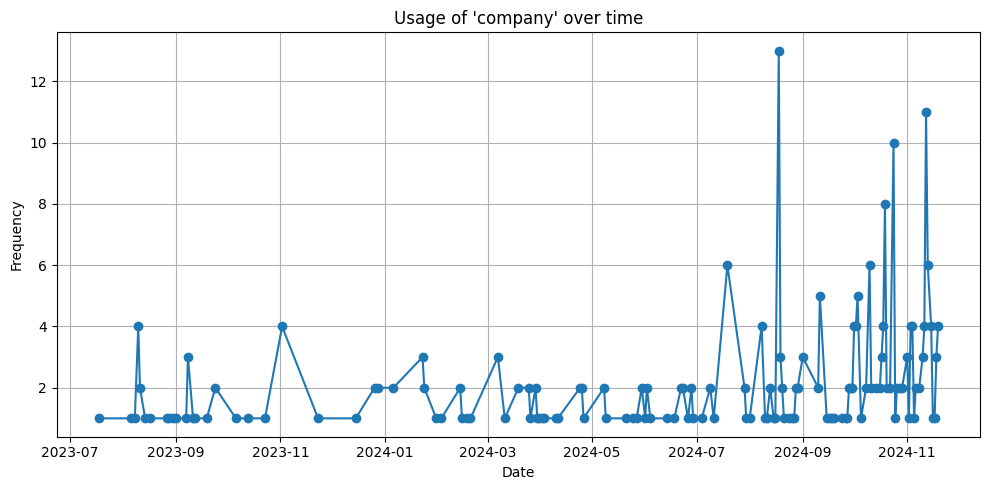

In [12]:
plot_word_frequency("company", words)